In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from skimage.color import gray2rgb
from tqdm import tqdm
import tifffile
from PIL import Image
import json
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import seaborn as sns
from sklearn.mixture import GaussianMixture
from anndata import AnnData


In [31]:
df_gloms = ad_pt_slide2.obs
df_gloms

,Disease,dpt_pseudotime,Pseudotime,Slide_ID,Ki67_prot,CD44_prot,TGFB,PDGF
polygon_flags,,,,,,,,
0_0011186_ANCA_X3_slide2,ANCA,0.557568,0.557568,0011186,3.169925,13.225659,0.039008,0.009414
0_0011186_ANCA_X4_slide2,ANCA,0.416435,0.416435,0011186,0.000000,1.000000,0.020137,0.072077
0_0011186_ANCA_X6_slide2,ANCA,0.417834,0.417834,0011186,12.573411,14.814282,0.004359,0.047995
0_0011186_Cntrl_X1_slide2,Control,0.000000,0.000000,0011186,0.000000,0.000000,0.001060,0.038192
0_0011186_Cntrl_X2_slide2,Control,0.106783,0.106783,0011186,0.000000,1.000000,0.033462,0.053815
...,...,...,...,...,...,...,...,...
7_0011186_Cntrl_X2_slide2,Control,0.239479,0.239479,0011186,3.000000,0.000000,0.005284,0.021387
8_0011186_Cntrl_X1_slide2,Control,0.075411,0.075411,0011186,10.202124,13.682007,0.006020,0.054870
8_0011186_Cntrl_X2_slide2,Control,0.283191,0.283191,0011186,0.000000,0.000000,0.005646,0.011361


In [33]:
df_all = adata.obs

In [34]:
adata.obs.columns

Index(['x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation',
       'area', 'avg_confidence', 'avg_assignment_confidence',
       'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area',
       'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob',
       'Slide_ID', 'sample', 'Disease', 'cell_name', 'Ki67', 'batch',
       'nichepca_domain', 'nichepca_domain_tuned', 'nichepca_glom_no',
       'CD44_prot', 'Ki67_prot', 'glom_ID', 'polygon_flags', 'is_in_polygon',
       'is_in_glom', 'is_in_periglom'],
      dtype='object')

In [17]:
ad_all =  sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/adata_with_polygons.h5ad")
ad_protein =  sc.read_h5ad("/data/projects/Behnam/xenium-cgn/notebooks/03_image_registration/data_level_1/adata_slide2_PECinPoly_Ki67_CD44_noX1andX8.h5ad")
ad_gloms =  sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/pseudotime.h5ad")

In [18]:
df_all = ad_all.obs
df_prot = ad_protein.obs
df_gloms = ad_gloms.obs

In [19]:
# Now we need to merge these: df_all, df_prot, df_gloms

In [20]:
df_merge = pd.merge(df_all, df_gloms, left_on='polygon_flags', right_index=True, suffixes=('', '_ptime'))
df_merge.index = ['-'.join(i.split('-')[0:2]) for i in df_merge.index]
df_prot.index = ['-'.join(i.split('-')[0:2]) for i in df_prot.index]
df_merge_final = pd.merge(df_merge, df_prot, right_index=True, left_index=True, how = 'inner', suffixes=('', '_protein'))

In [21]:
df_merge_final.shape, df_prot.shape

((737, 70), (737, 27))

In [22]:
df_merge_final_plot = df_merge_final[['x', 'y', 'celltype_l1', 'Pseudotime', 'Ki67_protein', 'CD44', 'polygon_flags']].copy()
df_merge_final_plot

,x,y,celltype_l1,Pseudotime,Ki67_protein,CD44,polygon_flags
cell_CR9fbacb852-117027,731.995284,17253.393345,PEC,0.106783,0,0,0_0011186_Cntrl_X2_slide2
cell_CR9fbacb852-117054,736.203982,17252.430278,PEC,0.106783,0,0,0_0011186_Cntrl_X2_slide2
cell_CR9fbacb852-117111,742.897142,17254.947588,PEC,0.106783,0,0,0_0011186_Cntrl_X2_slide2
cell_CR9fbacb852-117175,754.476935,17258.092233,PEC,0.106783,0,7,0_0011186_Cntrl_X2_slide2
cell_CR9fbacb852-117395,685.508616,17373.274537,PEC,0.106783,0,5,0_0011186_Cntrl_X2_slide2
...,...,...,...,...,...,...,...
cell_CR9fbacb852-42204,7411.122152,2745.057792,PEC,0.429149,1,13,5_0011186_SLE_X7_slide2
cell_CR9fbacb852-42217,7418.741944,2738.735971,PEC,0.429149,0,37,5_0011186_SLE_X7_slide2
cell_CR9fbacb852-43218,7491.903544,2741.394959,PEC,0.429149,2,3,5_0011186_SLE_X7_slide2
cell_CR9fbacb852-301474,7306.837825,2809.454295,PEC,0.429149,0,15,5_0011186_SLE_X7_slide2


In [48]:
tokeep = [False if len(i.split(',')) > 1 else True for i in df_merge_final_plot['polygon_flags']]
df_merge_final_plot = df_merge_final_plot.loc[tokeep]
df_merge_final_plot

,x,y,celltype_l1,Pseudotime,Ki67_protein,CD44,polygon_flags
cell_CR9fbacb852-117027,731.995284,17253.393345,PEC,0.106783,0,0,0_0011186_Cntrl_X2_slide2
cell_CR9fbacb852-117054,736.203982,17252.430278,PEC,0.106783,0,0,0_0011186_Cntrl_X2_slide2
cell_CR9fbacb852-117111,742.897142,17254.947588,PEC,0.106783,0,0,0_0011186_Cntrl_X2_slide2
cell_CR9fbacb852-117175,754.476935,17258.092233,PEC,0.106783,0,7,0_0011186_Cntrl_X2_slide2
cell_CR9fbacb852-117395,685.508616,17373.274537,PEC,0.106783,0,5,0_0011186_Cntrl_X2_slide2
...,...,...,...,...,...,...,...
cell_CR9fbacb852-42204,7411.122152,2745.057792,PEC,0.429149,1,13,5_0011186_SLE_X7_slide2
cell_CR9fbacb852-42217,7418.741944,2738.735971,PEC,0.429149,0,37,5_0011186_SLE_X7_slide2
cell_CR9fbacb852-43218,7491.903544,2741.394959,PEC,0.429149,2,3,5_0011186_SLE_X7_slide2
cell_CR9fbacb852-301474,7306.837825,2809.454295,PEC,0.429149,0,15,5_0011186_SLE_X7_slide2


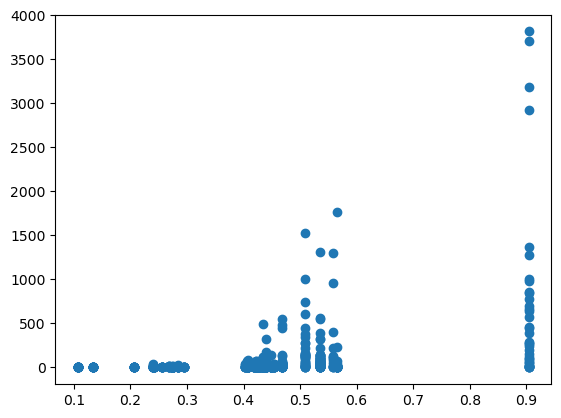

In [49]:
plt.scatter(df_merge_final_plot['Pseudotime'],df_merge_final_plot['CD44'])

Text(0.5, 1.0, 'CD44 per PECs in glom')

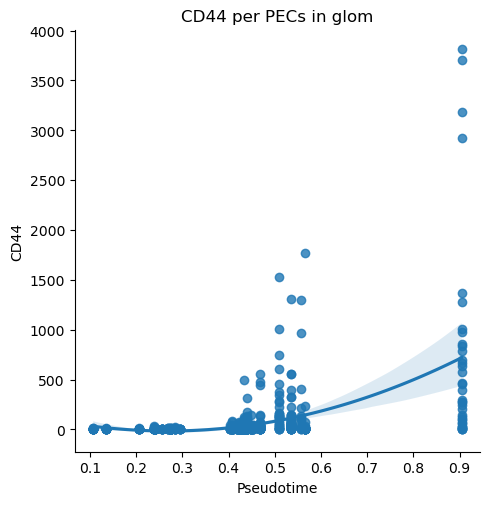

In [64]:
ax = sns.lmplot(data=df_merge_final_plot,x="Pseudotime",y="CD44", order=2, scatter=True, palette="colorblind")
plt.title("CD44 per PECs in glom")
#plt.savefig("glom_score_lines_with_ci_tgf_all_targets.pdf", bbox_inches="tight")

Text(0.5, 1.0, 'Ki67 per PECs in glom')

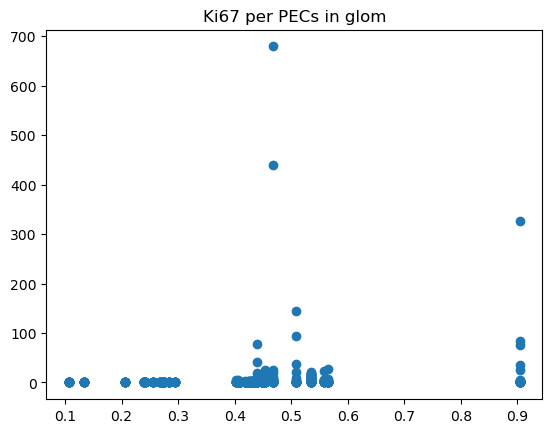

In [65]:
plt.scatter(df_merge_final_plot['Pseudotime'], df_merge_final_plot['Ki67_protein'])
plt.title("Ki67 per PECs in glom")
#plt.ylim(0,20)

Text(0.5, 1.0, 'Ki67 per PECs in glom')

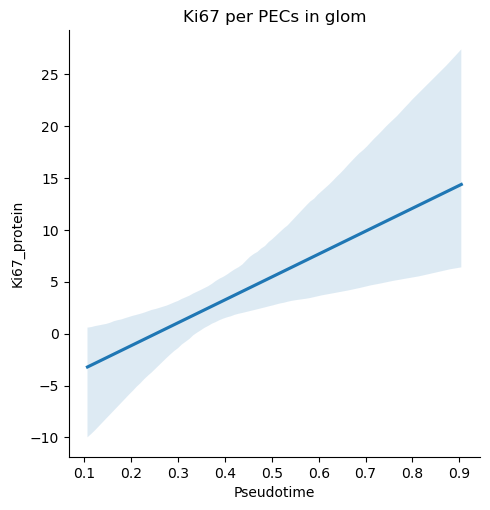

In [66]:
ax = sns.lmplot(data=df_merge_final_plot,x="Pseudotime",y="Ki67_protein", order=1, scatter=False, palette="colorblind")
plt.title("Ki67 per PECs in glom")

In [2]:
# grouped = df_merge_final_plot.groupby('polygon_flags')[['Ki67_protein', 'CD44']].sum()

In [67]:
grouped = df_merge_final_plot.groupby('polygon_flags', as_index=False).agg({
    'Ki67_protein': 'mean',
    'CD44': 'mean',
    'Pseudotime': 'first'
})

# grouped.sort_values("Pseudotime")

Text(0.5, 1.0, 'average CD44+ PECs per gloms')

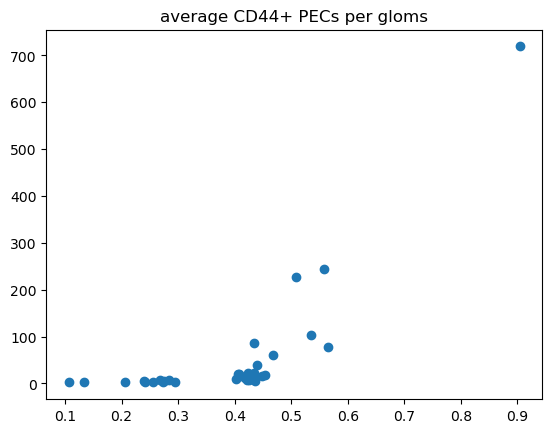

In [68]:
plt.scatter(grouped['Pseudotime'], grouped['CD44'])
plt.title("average CD44+ PECs per gloms")

Text(0.5, 1.0, 'average CD44+ PECs per gloms')

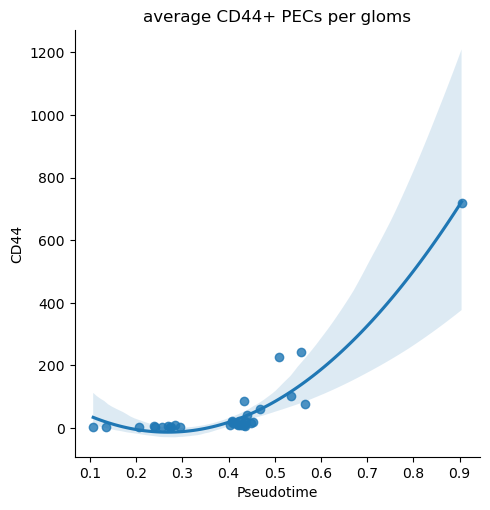

In [69]:
ax = sns.lmplot(data=grouped,x="Pseudotime",y="CD44", order=2, scatter=True, palette="colorblind")
plt.title("average CD44+ PECs per gloms")

Text(0.5, 1.0, 'average Ki67+ PECs per gloms')

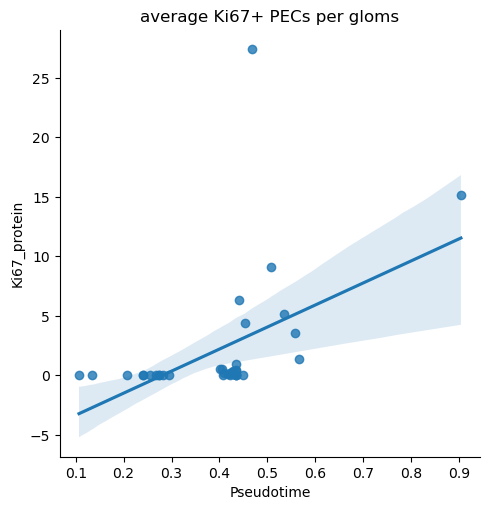

In [70]:
ax = sns.lmplot(data=grouped,x="Pseudotime",y="Ki67_protein", order=1, scatter=True, palette="colorblind")
plt.title("average Ki67+ PECs per gloms")

In [ ]:
from sklearn.mixture import GaussianMixture

# df_PECs is the DataFrame with gene expression data
label_gene_expression = df_PECs[['MKI67']]  

#  Histogram
plt.figure(figsize=(10, 6))
plt.hist(label_gene_expression['MKI67'], bins=50, edgecolor='black')
plt.title('Gene Expression Histogram for Ki67')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.show()

#  Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(label_gene_expression['MKI67'], fill=True)
plt.title('Density Plot for Ki67 Gene Expression')
plt.xlabel('Expression Level')
plt.ylabel('Density')
plt.show()



In [ ]:
# Reshaping into a two-dimensional array with one column 
ki67_reshaped = label_gene_expression['MKI67'].values.reshape(-1, 1)

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(ki67_reshaped)
means = gmm.means_.flatten()
means


# Determine the cutoff for Ki67 expression
cutoff = (means[0] + means[1]) / 2
print(f"Suggested cutoff for Ki67 expression: {cutoff}")

#cutoff = 0.5
print(f"Cutoff used for Ki67 expression: {cutoff}")


# Add a new column to label cells as Positive or Negative
label_gene_expression['MKI67_Label'] = label_gene_expression['MKI67'].apply(lambda x: 'Positive' if x >= cutoff else 'Negative')


In [ ]:
print(label_gene_expression.head())

In [ ]:
# Adding the MKI67 label columns to the df of other gene expression values
df_PECs_labeled = pd.merge(df_PECs, label_gene_expression, left_index=True, right_index=True, how='inner')

In [ ]:
df_PECs_labeled

In [ ]:
# Group by 'polygon_flags' and count Ki67 Pos PECs within each group
positive_counts = df_PECs_labeled[df_PECs_labeled['MKI67_Label'] == 'Positive'].groupby('polygon_flags').size()

# Count the total number of cells within each polygon flag
total_counts = df_PECs_labeled.groupby('polygon_flags').size()

# Calculate the percentage of Ki67 Pos PECs for each polygon flag
percentage_positive = (positive_counts / total_counts) * 100

# Combine counts and percentages into a single DataFrame for easier viewing
Ki67_pos_perc = pd.DataFrame({
  'Ki67_Positive_Count': positive_counts,
  'Total_Cells': total_counts,
  'Percentage_Positive': percentage_positive
}).reset_index()



In [ ]:
Ki67_pos_perc

In [ ]:
# Reset the index to ensure 'polygon_flag' becomes a column
df_ps_reset = df_ps.reset_index()

# Extract 'polygon_flag' and 'Pseudotime' into a new DataFrame
PT_info = df_ps_reset[['polygon_flags', 'Pseudotime']]


print(PT_info.head())

In [ ]:
df_PECs_labeled_PT = pd.merge(df_PECs_labeled, PT_info, on=['polygon_flags', 'polygon_flags'], how='inner')

In [ ]:
df_PECs_labeled_PT

In [ ]:
all_merged_df_PECs = pd.merge(df_PECs_labeled_PT, Ki67_pos_perc, on=['polygon_flags', 'polygon_flags'], how='inner')


In [ ]:
all_merged_df_PECs

In [ ]:
# Filter the DataFrame to exclude rows where 'Total_Cells' is less than 5
filtered_df_PECs = all_merged_df_PECs[all_merged_df_PECs['Total_Cells'] >= 5]

In [ ]:
# Sort by 'Pseudotime'
sorted_df_PECs = filtered_df_PECs.sort_values(by='Pseudotime')

In [ ]:
filtered_df_PECs

In [ ]:
sorted_df_PECs

In [ ]:
# Plot: Percentage of Ki67 Positive PECs vs. Pseudotime
# --------------------------------------

# Use sns.lmplot to fit a polynomial curve of a specified degree (e.g., 2 or 3)
ax = sns.lmplot(
  data=sorted_df_PECs,
  x="Pseudotime",
  y="Percentage_Positive",
  order=2,  # Adjust this to the desired polynomial degree
  scatter=False,  # Only plot the regression line initially
  #color="red",  # Set line color for differentiation
  ci=None  # Optionally remove confidence interval shading if not needed
)

# Overlay scatter plot on top of the line plot
plt_ax = ax.ax  # Access the underlying matplotlib axis from lmplot
sns.scatterplot(
  data=sorted_df_PECs,
  x="Pseudotime",
  y="Percentage_Positive",
  ax=plt_ax,
  #color="blue",  # Scatter point color
  s=40  # Adjust point size if necessary
)

# Customize labels and add a title
ax.set_ylabels("Percentage of Ki67 Positive PECs")
ax.set_xlabels("Pseudotime")
plt.title("Percentage of Ki67 Positive PECs Over Pseudotime")

# Save and display the plot
filename = "Percentage_Ki67_Positive_Pseudotime.pdf"
plt.savefig(filename, bbox_inches="tight")
plt.show()

# Print a message to confirm the file was saved
print(f"Plot saved as: {filename}")


In [ ]:
from anndata import AnnData
adata_glom_PECs = AnnData(gene_counts_PECs, obs=df_ps.loc[gene_counts_PECs.index.tolist()])

In [ ]:
sc.pp.normalize_total(adata_glom_PECs)
sc.pp.log1p(adata_glom_PECs)
adata_glom_PECs.obs.head()

In [ ]:
tmp = adata_glom_PECs.copy() 

In [ ]:
### PDGF pathway #####
# Biocarta PDGF pathway
#https://www.gsea-msigdb.org/gsea/msigdb/Human/geneset/BIOCARTA_PDGF_PATHWAY.html
pdgf_biocarta = [ "PIK3R1", "PIK3CA", "PRKCA", "SOS1", "MAPK3", "MAPK3", "ELK1", "SHC1", "SHC1", "HRAS", 
    "SHC1", "PIK3R1", "ELK1", "CSNK2A1", "GRB2", "JAK1", "JUN", "PDGFA", "PIK3CG", "PLCG1", 
    "PRKCA", "PRKCB", "MAPK3", "MAPK8", "MAP2K1", "RAF1", "RASA1", "MAP2K4", "SHC1", "SRF", 
    "STAT3", "STAT5A", "ELK1", "FOS", "HRAS", "SOS1", "MAP3K1", "PDGFRA", "PIK3CA", "STAT1", 
    "RASA1", "PDGFA", "MAPK8", "MAPK8", "STAT1", "STAT3", "HRAS", "CSNK2A1", "CSNK2A1", 
    "PIK3R1", "PIK3R1", "PIK3R1", "PLCG1", "SHC1", "GRB2", "PRKCB", "STAT3"]

#https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/REACTOME_SIGNALING_BY_PDGFR_IN_DISEASE.html
pdgf_Reactome = [ "PIK3CB", "PIK3R2", "KANK1", "BIN2", "WDR48", "STAT1", "STRN", "SOS1", 
                         "PIK3CA", "KDR", "KRAS", "PDGFRA", "ETV6", "GOLGA4", "FIP1L1", "PIK3R1", 
                         "STAT3", "HRAS", "GRB2", "NRAS", "HRAS"]

#genes_PMID_19030102_discussion section
pdgf_PMID_19030102 = [ "FOS", "NR4A1", "ZFP36", "EGR2", "NR4A2", "EGR3", "FOSB", "ATF3", "JUN", "IER3", 
           "ADRB2", "DUSP6", "MCL1", "RGS2", "MYC", "F3", "BHLHB2", "GEM", "EGR1", "LIF", 
           "CEBPB", "PTGS2", "ERRFI1", "JUNB", "FOSL1", "ERRFI1", "EREG", "HBEGF", "CH25H", 
           "HOMER1", "PHLDA1", "FOS", "KLF10", "FOSB", "SERPINE1", "DUSP5", "EREG", "GEM", 
           "HOMER1", "HBEGF", "TRIB1", "CCL2", "NFIL3", "LBH", "IER2", "MMP13", "GS2", "AREG", 
           "RSBN1", "LIF", "TNFRSF11B", "CXCL1", "NFKBIZ", "DUSP4", "CCL7", "RSBN1", "RGS2", 
           "IER3", "ARL5B", "BTG2", "ADAMTS1", "BTG2", "IER5", "HES1", "RGS2", "AXUD1", 
           "MMP3", "PTGER4"]


pdgf_genes_biocarta = [e for e in tmp.var.index.tolist() if 
              e in ["PDGFA", "PDGFB", "PDGFRB", "PDGFRA"] or 
              e in pdgf_biocarta ]

pdgf_genes_biocarta_targets = [e for e in tmp.var.index.tolist() if 
              e in ["PDGFA", "PDGFB", "PDGFRB", "PDGFRA"] or 
              e in pdgf_PMID_19030102 or 
              e in pdgf_biocarta ]

pdgf_genes_Reactome = [e for e in tmp.var.index.tolist() if 
              e in ["PDGFA", "PDGFB", "PDGFRB", "PDGFRA"] or 
              e in pdgf_Reactome]

pdgf_genes_Reactome_targets = [e for e in tmp.var.index.tolist() if 
              e in ["PDGFA", "PDGFB", "PDGFRB", "PDGFRA"] or 
              e in pdgf_PMID_19030102 or 
                e in pdgf_Reactome]

pdgf_genes_biocarta = sorted(list(set(pdgf_genes_biocarta)))
pdgf_genes_biocarta_targets = sorted(list(set(pdgf_genes_biocarta_targets)))
pdgf_genes_Reactome = sorted(list(set(pdgf_genes_Reactome)))
pdgf_genes_Reactome_targets = sorted(list(set(pdgf_genes_Reactome_targets)))


### TGFB pathway #####
#https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HALLMARK_TGF_BETA_SIGNALING.html
tgf_genes_hallmarkMsig = ["ACVR1", "APC", "ARID4B", "BCAR3", "BMP2", "BMPR1A", "BMPR2", "CDH1", "CDK9", 
                        "CDKN1C", "CTNNB1", "ENG", "FKBP1A", "FNTA", "FURIN", "HDAC1", "HIPK2", "ID1", 
                        "ID2", "ID3", "IFNGR2", "JUNB", "KLF10", "LEFTY2", "LTBP2", "MAP3K7", "NCOR2", 
                        "NOG", "PMEPA1", "PPM1A", "PPP1CA", "PPP1R15A", "RAB31", "RHOA", "SERPINE1", 
                        "SKI", "SKIL", "SLC20A1", "SMAD1", "SMAD3", "SMAD6", "SMAD7", "SMURF1", "SMURF2", 
                        "SPTBN1", "TGFB1", "TGFBR1", "TGIF1", "THBS1", "TJP1", "TRIM33", "UBE2D3", 
                        "WWTR1", "XIAP"]
tgf_genes = [e for e in tmp.var.index.tolist() if 
              e in [ "TGFB1", "TGFBI", "TGFBR1"] or 
              e in tgf_genes_hallmarkMsig ]

tgf_genes = sorted(list(set(tgf_genes)))

In [ ]:
sc.tl.score_genes(tmp, tgf_genes, score_name="TGFB", use_raw=False)
sc.tl.score_genes(tmp, pdgf_genes_biocarta, score_name="PDGF_bio", use_raw=False)
sc.tl.score_genes(tmp, pdgf_genes_biocarta_targets, score_name="PDGF_bio_targets", use_raw=False)
sc.tl.score_genes(tmp, pdgf_genes_Reactome, score_name="PDGF_reactome", use_raw=False)
sc.tl.score_genes(tmp, pdgf_genes_Reactome_targets, score_name="PDGF_reactome_targets", use_raw=False)

In [ ]:
obs1 = tmp.obs[["Pseudotime"]]
obs1["expression"] = tmp.obs["PDGF_reactome"].tolist()
obs1["gene"] = "PDGF_reactome"

obs2 = tmp.obs[["Pseudotime"]]
obs2["expression"] = tmp.obs["TGFB"].tolist()
obs2["gene"] = "TGFB_score"

obs = pd.concat([obs2, obs1], axis=0)

ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=2, scatter=False, palette="colorblind")
ax.set_ylabels("Score in PECs")
ax.legend.set_title("")
#plt.savefig("glom_score_lines_with_ci_tgf_all_targets.pdf", bbox_inches="tight")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

order_value=2

# Create a new figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Ki67 data with the primary y-axis
sns.regplot(
    data=sorted_df_PECs,
    x="Pseudotime",
    y="Percentage_Positive",
    order=order_value,
    scatter=False,
    color="blue",
    ax=ax1,
    label="Ki67 Positive PECs",
    ci=None
)

# Scatter plot for Ki67 data
sns.scatterplot(
    data=sorted_df_PECs,
    x="Pseudotime",
    y="Percentage_Positive",
    ax=ax1,
    s=40,
    color="blue"
)

# Customize primary y-axis (left)
ax1.set_ylabel("Percentage of Ki67 Positive PECs")
ax1.set_xlabel("Pseudotime")
ax1.set_title("Percentage of Ki67 Positive PECs with TGFB and PDGF Scores Over Pseudotime")
ax1.legend(loc="upper left")

# Create secondary y-axis (right) for the scores
ax2 = ax1.twinx()

# Plot TGFB score on the secondary y-axis
sns.regplot(
    data=obs[obs["gene"] == "TGFB_score"],
    x="Pseudotime",
    y="expression",
    order=order_value,
    scatter=False,
    color="orange",
    ax=ax2,
    label="TGFB (Extended)",
    ci=None
)

# Plot PDGF score on the secondary y-axis
sns.regplot(
    data=obs[obs["gene"] == "PDGF_reactome"],
    x="Pseudotime",
    y="expression",
    order=order_value,
    scatter=False,
    color="green",
    ax=ax2,
    label="PDGF_reactome",
    ci=None
)

# Customize secondary y-axis (right)
ax2.set_ylabel("Score in PECs")
ax2.legend(loc="upper right")

# Adjust the legends to avoid overlap
fig.tight_layout()

# Save and display the plot
filename = "Ki67_TGFB_PDGF_Pseudotime_dual_axis.pdf"
plt.savefig(filename, bbox_inches="tight")
plt.show()

# Confirmation message
print(f"Plot saved as: {filename}")


In [ ]:
# Example pattern to match
pattern = "PDGF"

# List comprehension to find all variable names in tmp.var.index that match the pattern
matched_variables = [e for e in tmp.var.index.tolist() if pattern in e]

# Print the matched variable names
print(matched_variables)


In [ ]:
pdgf_receptors = [e for e in tmp.var.index.tolist() if 
                e in [ "PDGFRB"]]

tgf_receptors = [e for e in tmp.var.index.tolist() if 
               e in [ "TGFBR1","TGFBR2"]]


pdgf_receptors = sorted(list(set(pdgf_receptors)))
tgf_receptors = sorted(list(set(tgf_receptors)))


sc.tl.score_genes(tmp, pdgf_receptors, score_name="pdgf_receptors", use_raw=False)
sc.tl.score_genes(tmp, tgf_receptors, score_name="tgf_receptors", use_raw=False)

obs1 = tmp.obs[["Pseudotime"]]
obs1["expression"] = tmp.obs["pdgf_receptors"].tolist()
obs1["gene"] = "pdgf_receptors"

obs2 = tmp.obs[["Pseudotime"]]
obs2["expression"] = tmp.obs["tgf_receptors"].tolist()
obs2["gene"] = "tgf_receptors"

obs = pd.concat([obs2, obs1], axis=0)

ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=2, scatter=False, palette="colorblind")
ax.set_ylabels("Score in PECs")
ax.legend.set_title("")
#plt.savefig("glom_score_lines_with_ci_tgf_all_targets.pdf", bbox_inches="tight")

In [ ]:
PDGFRB = [e for e in tmp.var.index.tolist() if 
                e in [ "PDGFRB"]]

TGFBR1 = [e for e in tmp.var.index.tolist() if 
               e in [ "TGFBR1"]]

TGFBR2 = [e for e in tmp.var.index.tolist() if 
          e in [ "TGFBR2"]]


PDGFRB = sorted(list(set(PDGFRB)))
TGFBR1 = sorted(list(set(TGFBR1)))
TGFBR2 = sorted(list(set(TGFBR2)))


sc.tl.score_genes(tmp, PDGFRB, score_name="PDGFRB", use_raw=False)
sc.tl.score_genes(tmp, TGFBR1, score_name="TGFBR1", use_raw=False)
sc.tl.score_genes(tmp, TGFBR2, score_name="TGFBR2", use_raw=False)


obs1 = tmp.obs[["Pseudotime"]]
obs1["expression"] = tmp.obs["PDGFRB"].tolist()
obs1["gene"] = "PDGFRB"

obs2 = tmp.obs[["Pseudotime"]]
obs2["expression"] = tmp.obs["TGFBR1"].tolist()
obs2["gene"] = "TGFBR1"

obs3 = tmp.obs[["Pseudotime"]]
obs3["expression"] = tmp.obs["TGFBR2"].tolist()
obs3["gene"] = "TGFBR2"

obs = pd.concat([obs1,obs2,obs3], axis=0)

ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=2, scatter=False, palette="colorblind")
ax.set_ylabels("Score in PECs")
ax.legend.set_title("")
#plt.savefig("glom_score_lines_with_ci_tgf_all_targets.pdf", bbox_inches="tight")

In [ ]:
ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=2, scatter=True, palette="colorblind")
ax.set_ylabels("Score in PECs")
ax.legend.set_title("")

In [ ]:
gene_counts_PECs

In [ ]:
gene_counts_PECs.reset_index(inplace=True)
gene_counts_PECs

In [ ]:
gene_counts_PECs['disease'] = gene_counts_PECs['polygon_flags'].apply(lambda x: x.split(',')[0].split('_')[2])

In [ ]:
gene_counts_PECs

In [ ]:
mean_df = gene_counts_PECs.groupby('disease').mean(numeric_only=True)

In [ ]:
mean_df

In [ ]:
custom_order = ['Cntrl', 'SLE', 'ANCA', 'GBM']

columns_to_plot = ['PDGFRB', 'TGFBR1', 'TGFBR2']
mean_df = mean_df.reindex(custom_order)

mean_df[columns_to_plot].plot(kind='bar', figsize=(10, 6))
# Add plot labels and title
plt.title('Mean Values of Selected Columns Across Diseases')
plt.xlabel('Disease')
plt.ylabel('Mean Value')
plt.legend(title='Columns', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Assuming gene_counts_PECs is defined similarly to the previous DataFrame, this will enhance styling aspects.

# Set up for publication-ready styling
plt.figure(figsize=(10, 6))
sns.set(style="ticks")  # 'ticks' style removes grid and provides a cleaner background

# Define custom order and colors (consistent with provided code)
custom_order = ['Cntrl', 'SLE', 'ANCA', 'GBM']
custom_colors = {'Cntrl': 'lightblue', 'SLE': 'salmon', 'ANCA': 'lightgreen', 'GBM': 'orange'}

# Create the violin plot with enhanced styling
sns.violinplot(data=gene_counts_PECs, x='disease', y='PDGFRB', order=custom_order, palette=custom_colors, inner=None)

# Overlay scatter plot with jitter and specified colors
sns.stripplot(data=gene_counts_PECs, x='disease', y='PDGFRB', order=custom_order, palette=custom_colors, jitter=True, alpha=0.6, edgecolor="gray")

# Add prominent median lines for each disease
for disease in custom_order:
    median_value = gene_counts_PECs[gene_counts_PECs['disease'] == disease]['PDGFRB'].median()
    plt.plot([custom_order.index(disease) - 0.2, custom_order.index(disease) + 0.2], 
             [median_value, median_value], 
             color='black', lw=3)

# Style adjustments for publication
plt.title('Distribution of PDGFRB Across Diseases', fontsize=16, fontweight='bold')
plt.xlabel('Disease', fontsize=14, fontweight='bold')
plt.ylabel('PDGFRB', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Thicken the axis lines
plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)

plt.tight_layout()
plt.show()


In [ ]:
# Assuming gene_counts_PECs is defined similarly to the previous DataFrame, this will enhance styling aspects.

# Set up for publication-ready styling
plt.figure(figsize=(10, 6))
sns.set(style="ticks")  # 'ticks' style removes grid and provides a cleaner background

# Define custom order and colors (consistent with provided code)
custom_order = ['Cntrl', 'SLE', 'ANCA', 'GBM']
custom_colors = {'Cntrl': 'lightblue', 'SLE': 'salmon', 'ANCA': 'lightgreen', 'GBM': 'orange'}

# Create the violin plot with enhanced styling
sns.violinplot(data=gene_counts_PECs, x='disease', y='TGFBR1', order=custom_order, palette=custom_colors, inner=None)

# Overlay scatter plot with jitter and specified colors
sns.stripplot(data=gene_counts_PECs, x='disease', y='TGFBR1', order=custom_order, palette=custom_colors, jitter=True, alpha=0.6, edgecolor="gray")

# Add prominent median lines for each disease
for disease in custom_order:
  median_value = gene_counts_PECs[gene_counts_PECs['disease'] == disease]['TGFBR1'].median()
plt.plot([custom_order.index(disease) - 0.2, custom_order.index(disease) + 0.2], 
         [median_value, median_value], 
         color='black', lw=3)

# Style adjustments for publication
plt.title('Distribution of TGFBR1 Across Diseases', fontsize=16, fontweight='bold')
plt.xlabel('Disease', fontsize=14, fontweight='bold')
plt.ylabel('TGFBR1', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Thicken the axis lines
plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)

plt.tight_layout()
plt.show()


In [ ]:
# Assuming gene_counts_PECs is defined similarly to the previous DataFrame, this will enhance styling aspects.

# Set up for publication-ready styling
plt.figure(figsize=(10, 6))
sns.set(style="ticks")  # 'ticks' style removes grid and provides a cleaner background

# Define custom order and colors (consistent with provided code)
custom_order = ['Cntrl', 'SLE', 'ANCA', 'GBM']
custom_colors = {'Cntrl': 'lightblue', 'SLE': 'salmon', 'ANCA': 'lightgreen', 'GBM': 'orange'}

# Create the violin plot with enhanced styling
sns.violinplot(data=gene_counts_PECs, x='disease', y='TGFBR2', order=custom_order, palette=custom_colors, inner=None)

# Overlay scatter plot with jitter and specified colors
sns.stripplot(data=gene_counts_PECs, x='disease', y='TGFBR2', order=custom_order, palette=custom_colors, jitter=True, alpha=0.6, edgecolor="gray")

# Add prominent median lines for each disease
for disease in custom_order:
  median_value = gene_counts_PECs[gene_counts_PECs['disease'] == disease]['TGFBR2'].median()
plt.plot([custom_order.index(disease) - 0.2, custom_order.index(disease) + 0.2], 
         [median_value, median_value], 
         color='black', lw=3)

# Style adjustments for publication
plt.title('Distribution of TGFBR2 Across Diseases', fontsize=16, fontweight='bold')
plt.xlabel('Disease', fontsize=14, fontweight='bold')
plt.ylabel('TGFBR2', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Thicken the axis lines
plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)

plt.tight_layout()
plt.show()


In [ ]:
sub_adata_poly

In [ ]:
df_sub_adata_poly = sub_adata_poly.to_df(layer="counts")
df_sub_adata_poly = pd.concat([df_sub_adata_poly, sub_adata_poly.obs[["polygon_flags", "celltype_l1", "Disease"]]], axis=1)

In [ ]:
df_sub_adata_poly

In [ ]:
genes_to_plot = ['TGFB1', 'PDGFA', 'PDGFB']

# Set the figure size and style
for gene in genes_to_plot:
    plt.figure(figsize=(12, 8))
    sns.set(style="ticks")
    
    # Create violin plot with scale adjustments and less bandwidth for smoother violins
    sns.violinplot(data=df_sub_adata_poly, x='Disease', y=gene, order=custom_order, inner=None, 
                   scale='width', bw=0.5)
    
    # Overlay scatter plot with increased jitter and transparency for better visibility
    sns.stripplot(data=df_sub_adata_poly, x='Disease', y=gene, order=custom_order, color='black', 
                  jitter=0.3, alpha=0.5)
    
    # Add prominent median lines
    for Disease in custom_order:
        median_value = df_sub_adata_poly[df_sub_adata_poly['Disease'] == Disease][gene].median()
        plt.plot([custom_order.index(Disease) - 0.2, custom_order.index(Disease) + 0.2], 
                 [median_value, median_value], color='black', lw=3)

    # Customize plot titles and labels
    plt.title(f'Distribution of {gene} Across Diseases', fontsize=16, fontweight='bold')
    plt.xlabel('Disease', fontsize=14, fontweight='bold')
    plt.ylabel(gene, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    # Optionally, set a y-axis limit if values are concentrated in a particular range
    # plt.ylim(bottom_limit, top_limit) # Uncomment and set limits as needed

    # Thicken axis lines for clarity
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)

    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Genes to plot
genes_to_plot = ['TGFB1', 'PDGFA', 'PDGFB']

# Define the custom order and cell types to exclude
custom_order = ['Cntrl', 'SLE', 'ANCA', 'GBM']
exclude_cells = ['ATL', 'CNT', 'DCT', 'DTL', 'TAL', 'IC', 'PC', 'PapE', 'NEU']

# Assuming df_sub_adata_poly is your DataFrame with gene expression data, disease, and cell type columns
# Filter out the specified cell types
filtered_df = df_sub_adata_poly[~df_sub_adata_poly['celltype_l1'].isin(exclude_cells)]


# Create stacked bar plots for the selected genes, excluding the specified cell types
for gene in genes_to_plot:
    # Group by Disease and cell type, then calculate the sum of gene expression for each group
    grouped_df_sub_adata_poly = filtered_df.groupby(['Disease', 'celltype_l1'])[gene].sum().unstack()
    
    # Reindex according to custom disease order
    grouped_df_sub_adata_poly = grouped_df_sub_adata_poly.reindex(custom_order)
    
    # Plot a stacked bar plot for the gene expression by cell type within each Disease condition
    grouped_df_sub_adata_poly.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    plt.title(f'{gene} Expression by Cell Type Across Diseases (Filtered)')
    plt.xlabel('Disease')
    plt.ylabel('Total Expression')
    plt.xticks(rotation=45)
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Genes to plot
genes_to_plot = ['TGFB1', 'PDGFA', 'PDGFB']

# Define the custom order and cell types to exclude
custom_order = ['Cntrl', 'SLE', 'ANCA', 'GBM']
exclude_cells = ['ATL', 'CNT', 'DCT', 'DTL', 'TAL', 'IC', 'PC', 'PapE', 'NEU']

# Filter out the specified cell types
filtered_df = df_sub_adata_poly[~df_sub_adata_poly['celltype_l1'].isin(exclude_cells)]

# Create stacked bar plots for the selected genes, showing proportions instead of absolute values
for gene in genes_to_plot:
    # Group by Disease and cell type, then calculate the sum of gene expression for each group
    grouped_df_sub_adata_poly = filtered_df.groupby(['Disease', 'celltype_l1'])[gene].sum().unstack()
    
    # Reindex according to custom disease order
    grouped_df_sub_adata_poly = grouped_df_sub_adata_poly.reindex(custom_order)
    
    # Calculate the proportion of each cell type within each disease
    proportions_df = grouped_df_sub_adata_poly.div(grouped_df_sub_adata_poly.sum(axis=1), axis=0)
    
    # Plot a stacked bar plot for the gene expression proportions by cell type within each Disease condition
    proportions_df.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    plt.title(f'Proportion of {gene} Expression by Cell Type Across Diseases (Filtered)')
    plt.xlabel('Disease')
    plt.ylabel('Proportion of Total Expression')
    plt.xticks(rotation=45)
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
df_ps

In [ ]:
df_sub_adata_poly

In [ ]:
df_sub_adata_poly_PT = pd.merge(df_sub_adata_poly,df_ps, on=["polygon_flags", "polygon_flags"])

In [ ]:
df_sub_adata_poly_PT

In [ ]:

df = pd.DataFrame(df_sub_adata_poly_PT)

# Define the gene to plot and the group by column
gene_to_plot = 'PDGFA'

# Group by 'polygon_flags' and 'Pseudotime' to calculate mean expression over pseudotime
mean_expression = df.groupby(['polygon_flags', 'Pseudotime'])[gene_to_plot].mean().reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot the mean expression for each group in 'polygon_flags'
for flag in mean_expression['polygon_flags'].unique():
    subset = mean_expression[mean_expression['polygon_flags'] == flag]
    plt.plot(subset['Pseudotime'], subset[gene_to_plot], label=f'Polygon Flag: {flag}', marker='o')

# Add labels and title
plt.title(f'Mean Expression of {gene_to_plot} Over Pseudotime')
plt.xlabel('Pseudotime')
plt.ylabel(f'Mean {gene_to_plot} Expression')
#plt.legend(title='Polygon Flags')
plt.ylim(0,0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df = pd.DataFrame(df_sub_adata_poly_PT)

# Define the gene to plot and the group by column
gene_to_plot = 'PDGFB'

# Group by 'polygon_flags' and 'Pseudotime' to calculate mean expression over pseudotime
mean_expression = df.groupby(['polygon_flags', 'Pseudotime'])[gene_to_plot].mean().reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot the mean expression for each group in 'polygon_flags'
for flag in mean_expression['polygon_flags'].unique():
    subset = mean_expression[mean_expression['polygon_flags'] == flag]
    plt.plot(subset['Pseudotime'], subset[gene_to_plot], label=f'Polygon Flag: {flag}', marker='o')

# Add labels and title
plt.title(f'Mean Expression of {gene_to_plot} Over Pseudotime')
plt.xlabel('Pseudotime')
plt.ylabel(f'Mean {gene_to_plot} Expression')
#plt.legend(title='Polygon Flags')
#plt.ylim(0,0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

df = pd.DataFrame(df_sub_adata_poly_PT)

# Define the gene to plot and the group by column
gene_to_plot = 'PDGFA'

# Group by 'polygon_flags' and 'Pseudotime' to calculate mean expression over pseudotime
mean_expression = df.groupby(['polygon_flags', 'Pseudotime'])[gene_to_plot].mean().reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot the mean expression for each group in 'polygon_flags'
for flag in mean_expression['polygon_flags'].unique():
    subset = mean_expression[mean_expression['polygon_flags'] == flag]
    plt.plot(subset['Pseudotime'], subset[gene_to_plot], label=f'Polygon Flag: {flag}', marker='o')

# Add labels and title
plt.title(f'Mean Expression of {gene_to_plot} Over Pseudotime')
plt.xlabel('Pseudotime')
plt.ylabel(f'Mean {gene_to_plot} Expression')
#plt.legend(title='Polygon Flags')
plt.ylim(0,0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Bin the 'Pseudotime' into 10 equal bins
df_sub_adata_poly_PT['Pseudotime_bin'] = pd.cut(df_sub_adata_poly_PT['Pseudotime'], bins=10, labels=False)

# Group by 'Pseudotime_bin' and 'celltype_l1' to sum PDGF expression for each cell type in each bin
binned_expression = df_sub_adata_poly_PT.groupby(['Pseudotime_bin', 'celltype_l1'])['PDGFA'].sum().unstack(fill_value=0)

# Create a stacked bar plot for PDGF expression across Pseudotime bins for each cell type
binned_expression.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title
plt.title('PDGF Expression Across Pseudotime Bins by Cell Type')
plt.xlabel('Pseudotime Bins')
plt.ylabel('Total PDGF Expression')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Bin the 'Pseudotime' into 10 equal bins
df_sub_adata_poly_PT['Pseudotime_bin'] = pd.cut(df_sub_adata_poly_PT['Pseudotime'], bins=20, labels=False)

# Group by 'Pseudotime_bin' and 'celltype_l1' to sum PDGF expression for each cell type in each bin
binned_expression = df_sub_adata_poly_PT.groupby(['Pseudotime_bin', 'celltype_l1'])['PDGFA'].sum().unstack(fill_value=0)

# Create a stacked bar plot for PDGF expression across Pseudotime bins for each cell type
binned_expression.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title
plt.title('PDGF Expression Across Pseudotime Bins by Cell Type')
plt.xlabel('Pseudotime Bins')
plt.ylabel('Total PDGF Expression')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Bin the 'Pseudotime' into 10 equal bins
df_sub_adata_poly_PT['Pseudotime_bin'] = pd.cut(df_sub_adata_poly_PT['Pseudotime'], bins=10, labels=False)

# Count the number of cells in each bin for each cell type
cell_counts = df_sub_adata_poly_PT.groupby(['Pseudotime_bin', 'celltype_l1']).size().unstack(fill_value=0)

# Sum PDGFA expression for each cell type in each pseudotime bin
total_expression = df_sub_adata_poly_PT.groupby(['Pseudotime_bin', 'celltype_l1'])['PDGFA'].sum().unstack(fill_value=0)

# Normalize the gene expression by dividing by the total number of cells in each bin
normalized_expression = total_expression.div(cell_counts)

# Create a stacked bar plot for the normalized PDGF expression across Pseudotime bins for each cell type
normalized_expression.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title
plt.title('Normalized PDGF Expression per Cell Across Pseudotime Bins by Cell Type')
plt.xlabel('Pseudotime Bins')
plt.ylabel('Average PDGF Expression per Cell')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Bin the 'Pseudotime' into 10 equal bins
df_sub_adata_poly_PT['Pseudotime_bin'] = pd.cut(df_sub_adata_poly_PT['Pseudotime'], bins=20, labels=False)

# Group by 'Pseudotime_bin' and 'celltype_l1' to sum PDGF expression for each cell type in each bin
binned_expression = df_sub_adata_poly_PT.groupby(['Pseudotime_bin', 'celltype_l1'])['TGFB1'].sum().unstack(fill_value=0)

# Create a stacked bar plot for PDGF expression across Pseudotime bins for each cell type
binned_expression.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title
plt.title('PDGF Expression Across Pseudotime Bins by Cell Type')
plt.xlabel('Pseudotime Bins')
plt.ylabel('Total PDGF Expression')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Bin the 'Pseudotime' into 10 equal bins
df_sub_adata_poly_PT['Pseudotime_bin'] = pd.cut(df_sub_adata_poly_PT['Pseudotime'], bins=10, labels=False)

# Count the number of cells in each bin for each cell type
cell_counts = df_sub_adata_poly_PT.groupby(['Pseudotime_bin', 'celltype_l1']).size().unstack(fill_value=0)

# Sum PDGFA expression for each cell type in each pseudotime bin
total_expression = df_sub_adata_poly_PT.groupby(['Pseudotime_bin', 'celltype_l1'])['TGFB1'].sum().unstack(fill_value=0)

# Normalize the gene expression by dividing by the total number of cells in each bin
normalized_expression = total_expression.div(cell_counts)

# Create a stacked bar plot for the normalized PDGF expression across Pseudotime bins for each cell type
normalized_expression.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title
plt.title('Normalized PDGF Expression per Cell Across Pseudotime Bins by Cell Type')
plt.xlabel('Pseudotime Bins')
plt.ylabel('Average PDGF Expression per Cell')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df_sub_adata_poly_PT

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


obs1 = df_sub_adata_poly_PT[["Pseudotime"]]
obs1["expression"] = df_sub_adata_poly_PT["PDGFA"].tolist()
obs1["polygon_flags"] = df_sub_adata_poly_PT["polygon_flags"].tolist()
obs1["gene"] = "PDGFA"

obs2 = df_sub_adata_poly_PT[["Pseudotime"]]
obs2["expression"] = df_sub_adata_poly_PT["TGFB1"].tolist()
obs2["polygon_flags"] = df_sub_adata_poly_PT["polygon_flags"].tolist()
obs2["gene"] = "TGFB1"

obs3 = df_sub_adata_poly_PT[["Pseudotime"]]
obs3["expression"] = df_sub_adata_poly_PT["PDGFB"].tolist()
obs3["polygon_flags"] = df_sub_adata_poly_PT["polygon_flags"].tolist()
obs3["gene"] = "PDGFB"

obs = pd.concat([obs2, obs1, obs3], axis=0)

ax=sns.lmplot(data=obs,x="Pseudotime",y="expression", hue="gene", order=2, scatter=False, palette="colorblind")
ax.set_ylabels("TGFb and PDGF ligands in the glom")
ax.legend.set_title("")


In [ ]:
obs

In [ ]:
obs_mean = obs.groupby(["polygon_flags", "gene"])["expression"].mean().reset_index()

In [ ]:
unique_pseudotime_counts = obs.groupby("polygon_flags")["Pseudotime"].nunique()


In [ ]:
unique_pseudotime_counts

In [ ]:
same_pseudotime_per_polygon = unique_pseudotime_counts.eq(1).all()


In [ ]:
# Display the result
if same_pseudotime_per_polygon:
    print("Each polygon has a single unique Pseudotime value.")
else:
    print("There are polygons with multiple Pseudotime values.")

# Optionally, display which polygons have multiple Pseudotime values
if not same_pseudotime_per_polygon:
    polygons_with_multiple_pseudotimes = unique_pseudotime_counts[unique_pseudotime_counts > 1]
    print("Polygons with multiple Pseudotime values:")
    print(polygons_with_multiple_pseudotimes)

In [ ]:
obs_mean = obs.groupby(["polygon_flags", "gene"]).agg({
    "expression": "mean",
    "Pseudotime": "first"  # Retain the unique Pseudotime value
}).reset_index()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#####################

order_value=2

# Create a new figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Ki67 data with the primary y-axis
sns.regplot(
  data=sorted_df_PECs,
  x="Pseudotime",
  y="Percentage_Positive",
  order=order_value,
  scatter=False,
  color="blue",
  ax=ax1,
  label="Ki67 Positive PECs",
  ci=None
)

# Scatter plot for Ki67 data
sns.scatterplot(
  data=sorted_df_PECs,
  x="Pseudotime",
  y="Percentage_Positive",
  ax=ax1,
  s=40,
  color="blue"
)

# Customize primary y-axis (left)
ax1.set_ylabel("Percentage of Ki67 Positive PECs")
ax1.set_xlabel("Pseudotime")
ax1.set_title("Percentage of Ki67 Positive PECs with TGFB and PDGF ligands in polygons Over Pseudotime")
ax1.legend(loc="upper left")

# Create secondary y-axis (right) for the scores
ax2 = ax1.twinx()

# Plot TGFB score on the secondary y-axis
sns.regplot(
  data=obs_mean[obs_mean["gene"] == "PDGFA"],
  x="Pseudotime",
  y="expression",
  order=order_value,
  scatter=True,
scatter_kws={'s':5},
  color="orange",
  ax=ax2,
  label="PDGFA",
  ci=None
)

# Plot PDGF score on the secondary y-axis
sns.regplot(
  data=obs_mean[obs_mean["gene"] == "TGFB1"],
  x="Pseudotime",
  y="expression",
  order=order_value,
  scatter=True,
    scatter_kws={'s':5},
  color="green",
  ax=ax2,
  label="TGFB1",
  ci=None
)


# Plot PDGF score on the secondary y-axis
sns.regplot(
  data=obs_mean[obs_mean["gene"] == "PDGFB"],
  x="Pseudotime",
  y="expression",
  order=order_value,
  scatter=True,
    scatter_kws={'s':5},
  color="red",
  ax=ax2,
  label="PDGFB",
  ci=None
)

# Customize secondary y-axis (right)
ax2.set_ylabel("Mean ligand expression in polygons")
ax2.legend(loc="upper right")
ax2.set_ylim(0, 0.4)

# Adjust the legends to avoid overlap
fig.tight_layout()

# Save and display the plot
filename = "Ki67_TGFB_PDGF_Pseudotime_dual_axis.pdf"
plt.savefig(filename, bbox_inches="tight")
plt.show()

# Confirmation message
print(f"Plot saved as: {filename}")
